In [2]:
import os
from datetime import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import glob
import shutil
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
!pip install ultralytics==8.0.20

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

from ultralytics import YOLO
from IPython.display import display, Image



Ultralytics YOLOv8.0.20 🚀 Python-3.10.9 torch-2.0.1 CPU
Setup complete ✅ (8 CPUs, 8.0 GB RAM, 102.1/228.3 GB disk)


In [3]:
#Load the models:

model_detect = YOLO('/Users/ldosnon/Desktop/runs/detect/train/weights/best.pt')  # load a custom model
model_classify = YOLO('/Users/ldosnon/Desktop/runs/classify/train/weights/best.pt')  # load a custom model

In [62]:
#Detect the region of interest (ROI) on the image
def detection_ROI(filename):
    model_detect.predict(filename, conf=0.5, project="/Users/ldosnon/Desktop/data_yolov8/RZD_yolov8_database/test/results/", name='prediction', save = False)
    ori_img = mpimg.imread(filename)
    #Get the bounding box
    results = model_detect(ori_img)  # return a list of Results objects
    R=results[0].boxes.boxes.numpy()
    box = R[0][0:4]
    return(box)

#Extract the region of interest (ROI) from the detection and extract intensity graph
def extract_roi(image_path, roi_coordinates):
    # Read the image
    img = cv2.imread(image_path)
    mask = np.zeros_like(img)
    roi_coordinates = np.array([roi_coordinates], dtype=np.int32)
    roi_coordinates = roi_coordinates.reshape((-1, 1, 2))
    x, y, w, h = cv2.boundingRect(roi_coordinates)
    roi=img[y:y+h, x:x+w]
    return roi

#Detect which type of readout it is: CT / CAT / C only
def analyse_roi(roi):
    filename = roi
    results = model_classify(filename)[0]
    results = results.probs.tolist()
    class_index = results.index(max(results))
    class_number = results.index(max(results))+1
    if model_classify.names[class_index] == "CAT":
        print("Using segmentation model trained on CAT data")
        path="/Users/ldosnon/Desktop/data_yolov8/Peak_segmentation_database/"
        model_segment = load_model(path + 'final_best_CAT_18-12-23')
    elif model_classify.names[class_index] == "CT":
        print("Using segmentation model trained on CT data")
        path="/Users/ldosnon/Desktop/data_yolov8/Peak_segmentation_database/"
        model_segment = load_model(path + 'final_best_CT_18-12-23')
    return model_segment

#Extract the intensity vs pixel graph from the region of interest (roi):
def extract_intensity_graph(roi):
    red_channel=roi[:, :, 0]
    #Get the intensity graph from a defined band
    width_rc=int(red_channel.shape[1])
    # Define the column you want to analyze
    column_to_analyze = int(width_rc * 0.5) # Example column number, you can change this
    # Extract pixel intensity values along the specified column
    thickness = 5  # Adjust the thickness as needed
    #Get the intensity value averaged over the band thickness
    intensity = []
    for i in range(thickness):
        intensity_i = red_channel[:, column_to_analyze+i]
        intensity.append(intensity_i)
    intensity_values_av=np.mean(intensity, axis=0, keepdims=True)[0,:]    
    intensity_values = red_channel[:, column_to_analyze]
    pixel_number = np.arange(len(intensity_values)+1)[1:]
    array_data = np.column_stack((pixel_number,intensity_values_av))
    return array_data


# Process the image and perform full detection - classification - segmentation
def process_intensity_data(model_segment, intensity_pixel_graph):
    data = intensity_pixel_graph
    scaler = MinMaxScaler()
    X_test = data[:, :2]  # Assuming the first two columns are 'pixel_number' and 'intensity'
    #Normalizing the data
    X_test = scaler.fit_transform(X_test)
    predictions = model_segment.predict(X_test)
    binary_predictions = (predictions >= 0.5).astype(int)
    X_test = scaler.inverse_transform(X_test) #####
    return X_test, binary_predictions

def plot_predictions(filename):
    box = detection_ROI(filename)
    roi = extract_roi(filename, box)
    model_segment = analyse_roi(roi) #This modify the type of model that will be loaded for the peak segmentation
    pixel_intensity_graph = extract_intensity_graph(roi)
    #Make the prediction of segmentation over the graph
    X_test, binary_predictions = process_intensity_data(model_segment, pixel_intensity_graph)
    
    
    #Plot original image and cropped ROI
    ori_img = mpimg.imread(filename)
    fig, axs = plt.subplots(1,2, figsize = (6,3))
    axs[0].imshow(ori_img)
    axs[0].set_title('Original image')

    axs[1].imshow(roi, cmap='gray')
    axs[1].set_title("Extracted Region of Interest")
    plt.show()
    
    # Plot the original data points and predicted regions
    plt.figure(figsize=(8, 3))
    plt.plot(X_test[:, 0], X_test[:, 1], label='Original Data')
    regions_pred = []
    current_region_start = None
    
    for i in range(binary_predictions.shape[0]):
        if binary_predictions[i] == 1:
            if current_region_start is None:
                        current_region_start = i
        else:
            if current_region_start is not None:
                        regions_pred.append((current_region_start, i - 1))
                        current_region_start = None

    if current_region_start is not None:
        regions_pred.append((current_region_start, binary_predictions.shape[0] - 1))
    for region_start, region_end in regions_pred:
        plt.axvspan(X_test[region_start, 0], X_test[region_end, 0], color='r', alpha=0.2, label=np.unique('Region Predicted as peaks'))
    

    plt.title("Model Predictions")
    plt.xlabel("Normalized Pixel Number")
    plt.ylabel("Normalized Intensity")
    plt.legend()
    plt.show()
    return X_test, regions_pred, binary_predictions


def process_images(image_folder):
    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            image_path = os.path.join(image_folder, filename)
            plot_predictions(image_path)
    
    



    
    
    
        


# Loop over multiple image

In [63]:
test_image_total_path = "/Users/ldosnon/Desktop/data_yolov8/RZD_yolov8_database/test/images"


Using segmentation model trained on CT data


4/4 [==============================] - 0s 700us/step


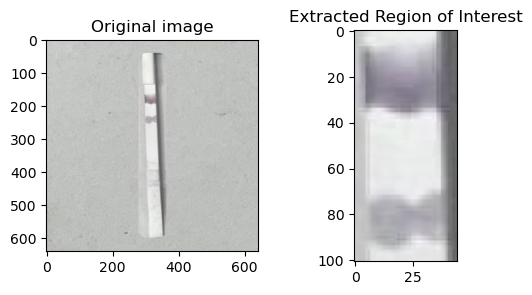

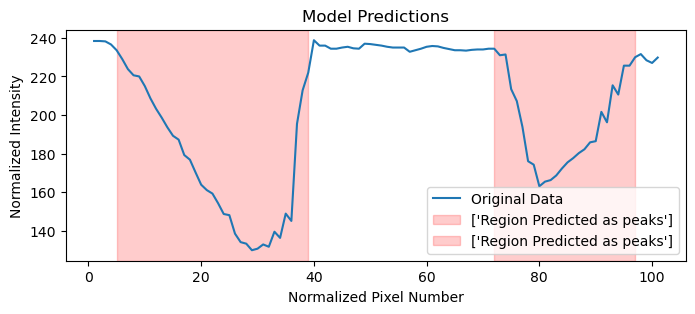

Using segmentation model trained on CT data


7/7 [==============================] - 0s 525us/step


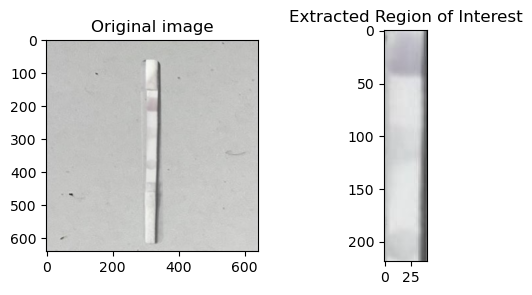

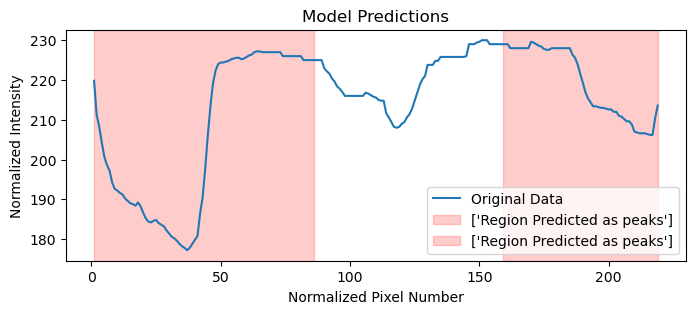

Using segmentation model trained on CT data


4/4 [==============================] - 0s 633us/step


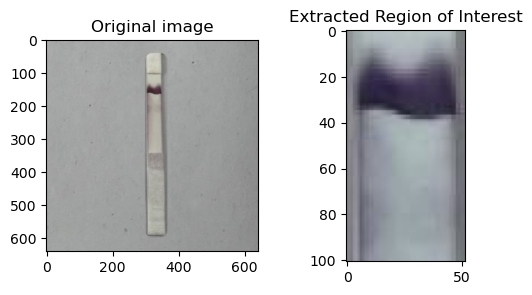

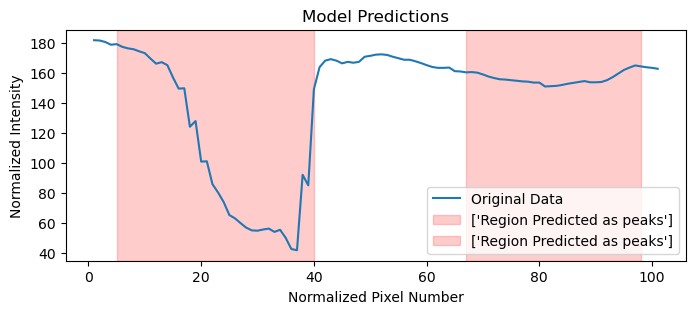

Using segmentation model trained on CAT data


5/5 [==============================] - 0s 698us/step


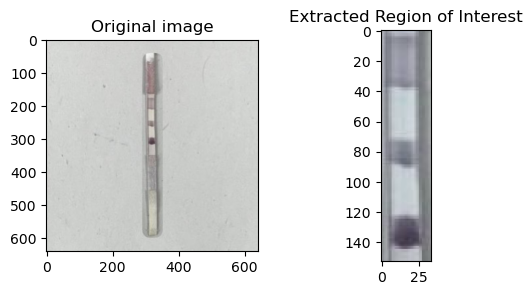

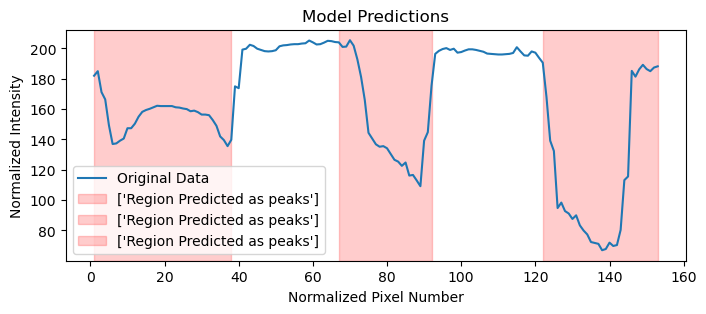

Using segmentation model trained on CAT data


6/6 [==============================] - 0s 552us/step


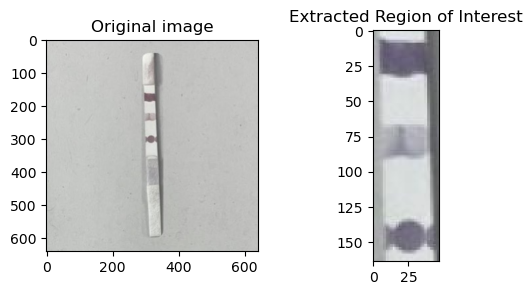

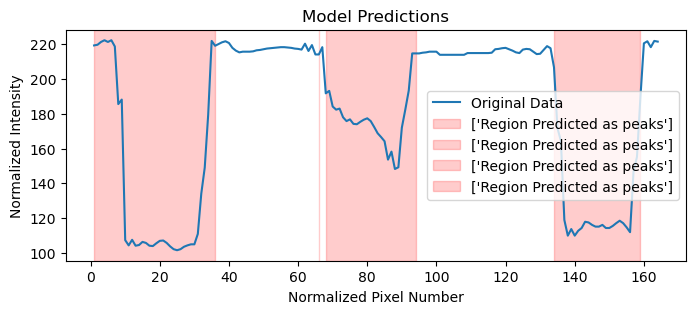

Using segmentation model trained on CAT data


7/7 [==============================] - 0s 518us/step


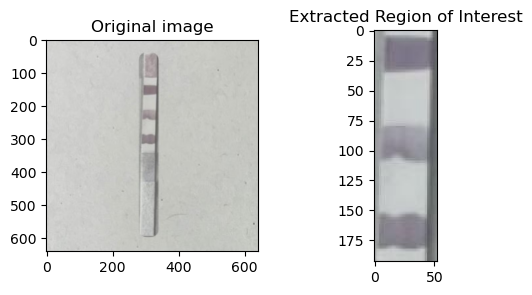

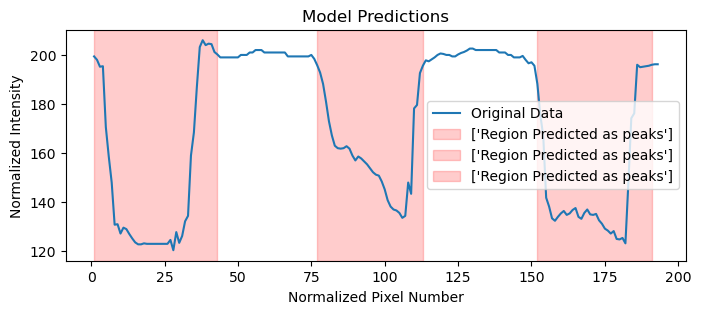

Using segmentation model trained on CT data


5/5 [==============================] - 0s 584us/step


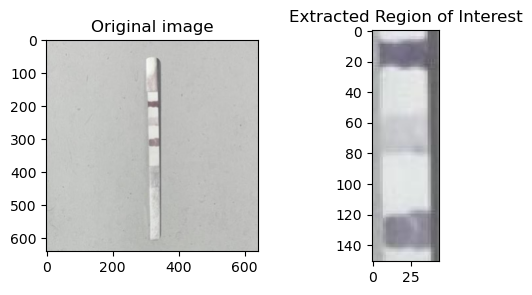

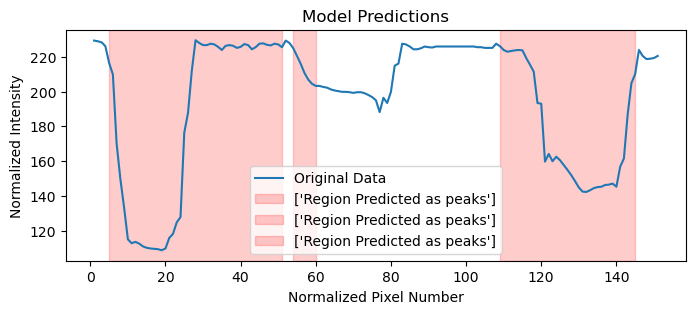

Using segmentation model trained on CT data


4/4 [==============================] - 0s 785us/step


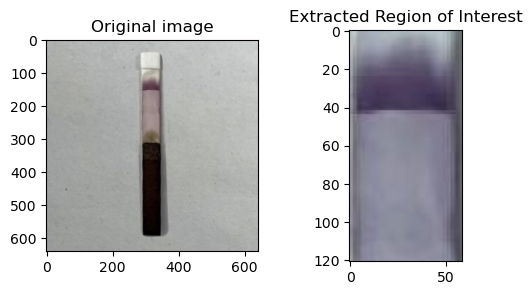

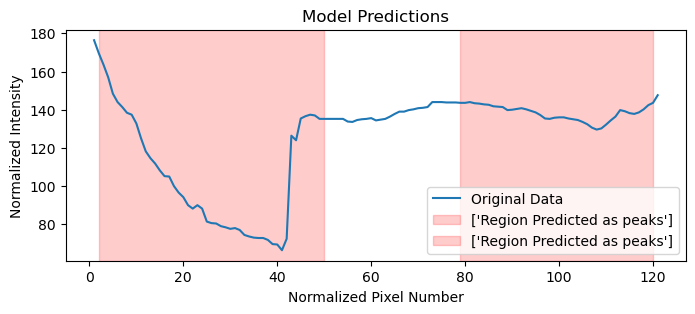

Using segmentation model trained on CT data


5/5 [==============================] - 0s 598us/step


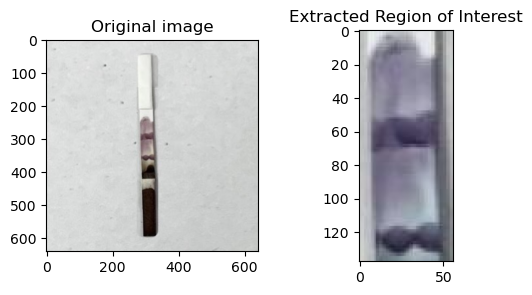

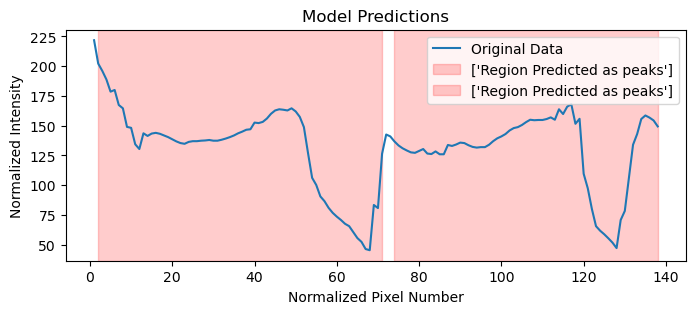

Using segmentation model trained on CT data


4/4 [==============================] - 0s 649us/step


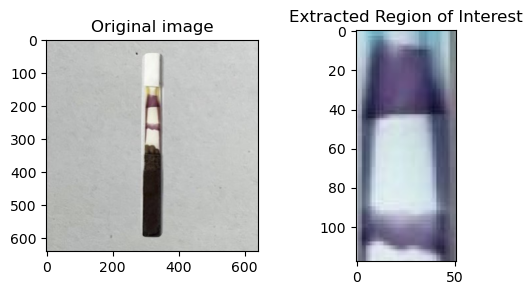

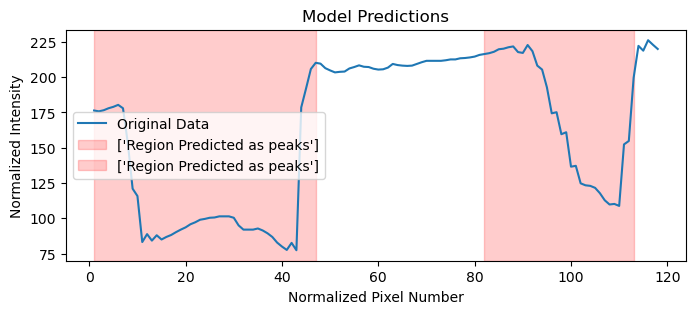

Using segmentation model trained on CAT data


7/7 [==============================] - 0s 513us/step


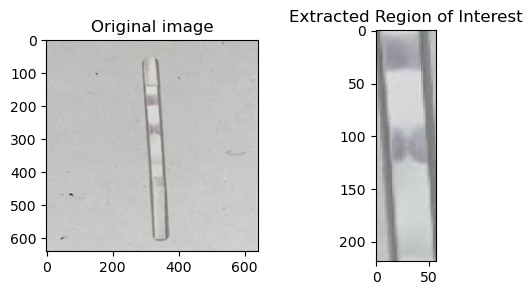

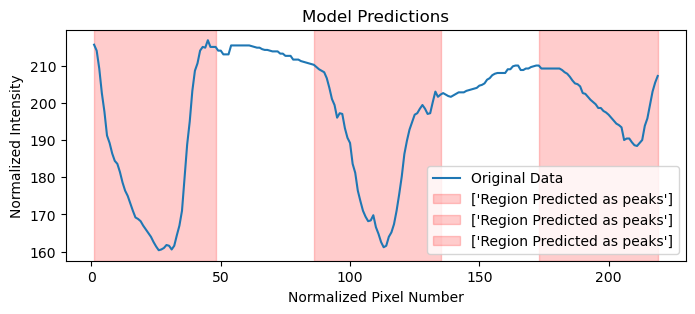

Using segmentation model trained on CT data


5/5 [==============================] - 0s 588us/step


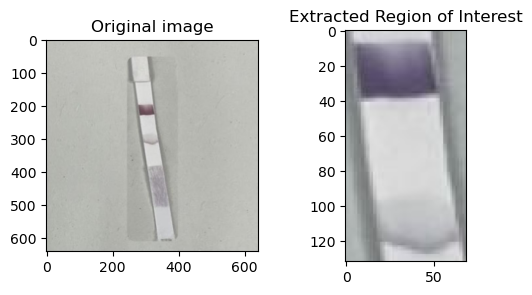

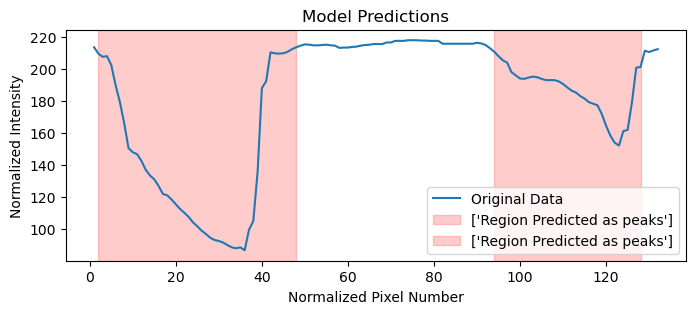

Using segmentation model trained on CT data


5/5 [==============================] - 0s 602us/step


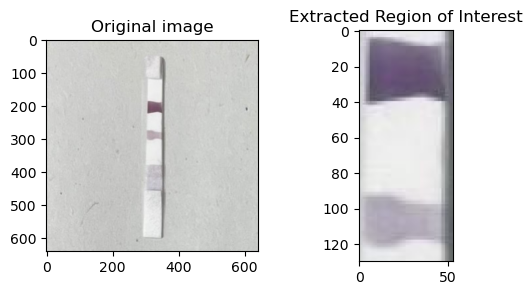

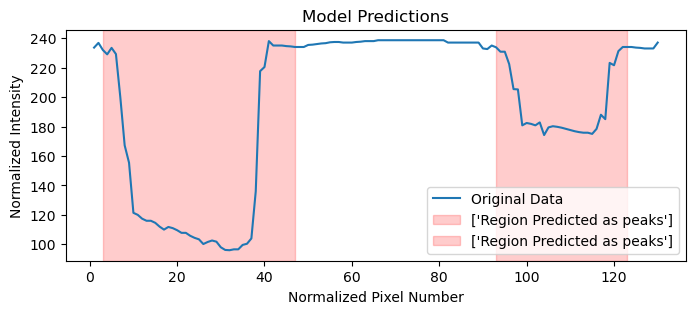

Using segmentation model trained on CT data


3/3 [==============================] - 0s 756us/step


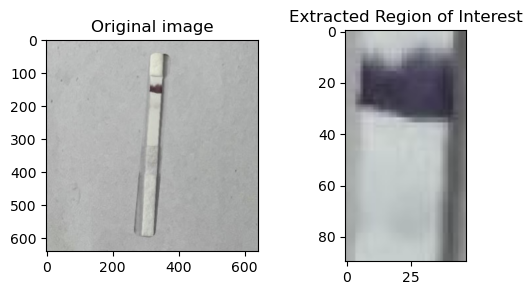

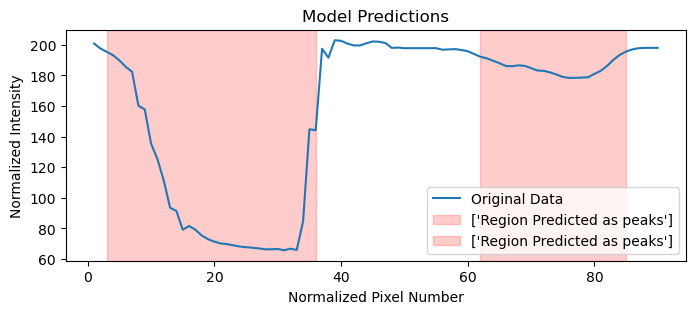

Using segmentation model trained on CAT data


3/3 [==============================] - 0s 755us/step


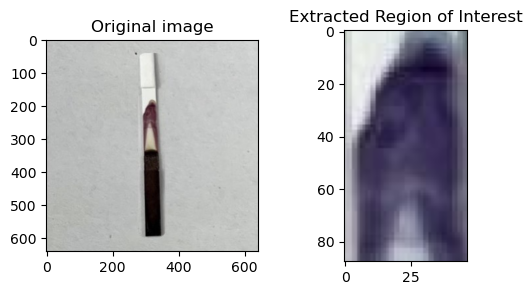

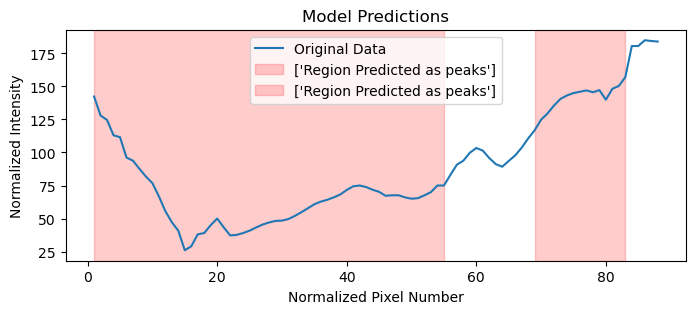

Using segmentation model trained on CT data


4/4 [==============================] - 0s 673us/step


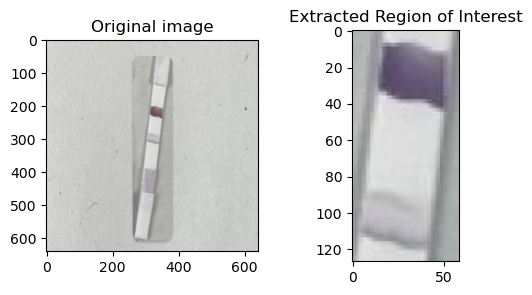

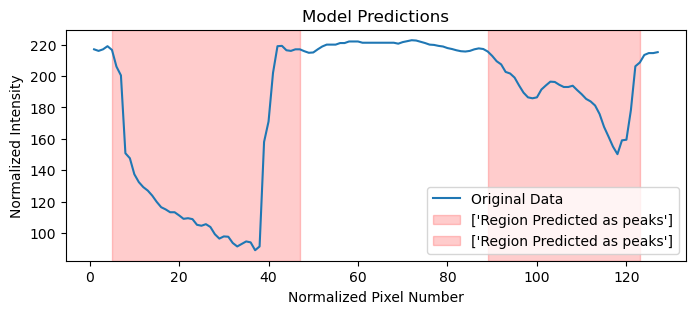

Using segmentation model trained on CT data


4/4 [==============================] - 0s 952us/step


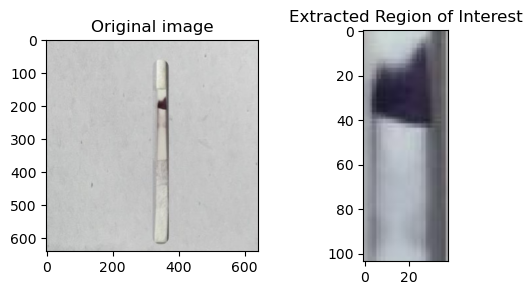

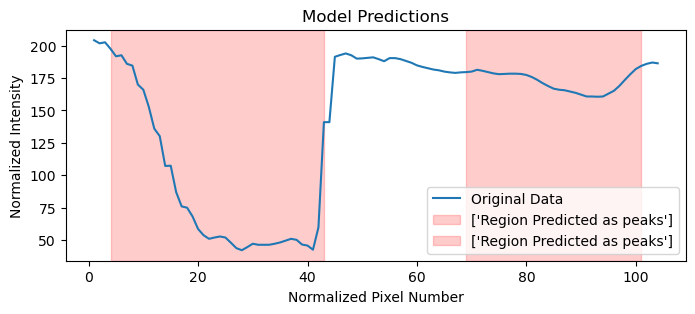

Using segmentation model trained on CT data


4/4 [==============================] - 0s 634us/step


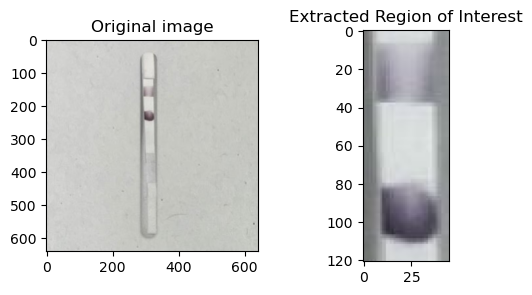

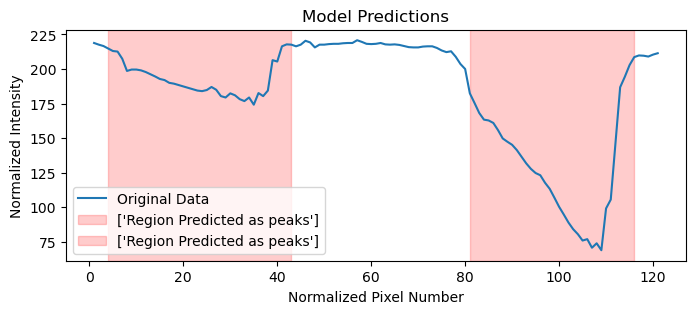

Using segmentation model trained on CT data


5/5 [==============================] - 0s 594us/step


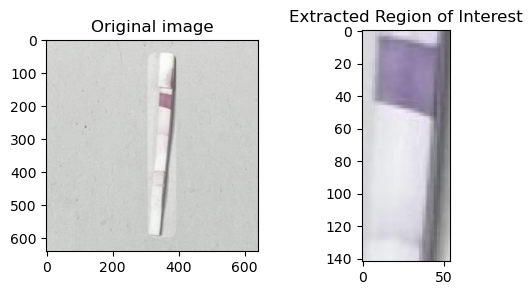

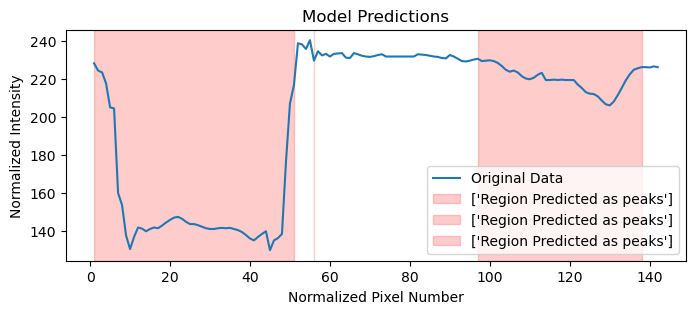

Using segmentation model trained on CAT data


4/4 [==============================] - 0s 601us/step


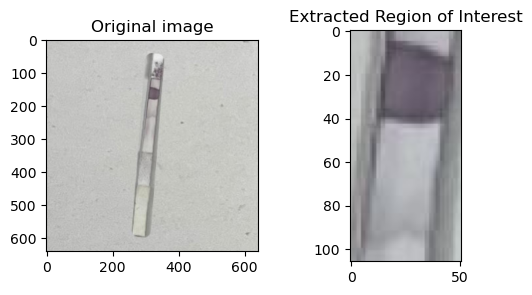

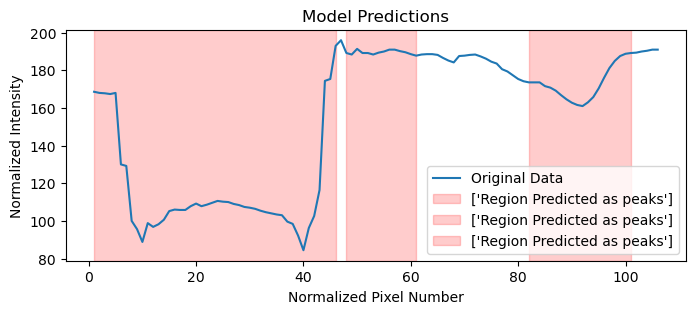

Using segmentation model trained on CT data


4/4 [==============================] - 0s 633us/step


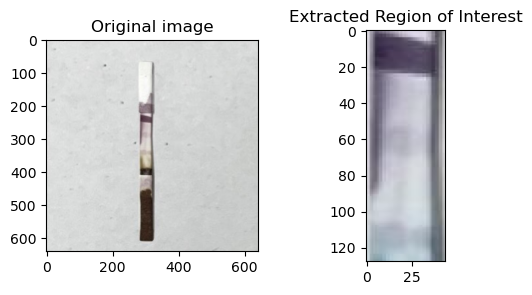

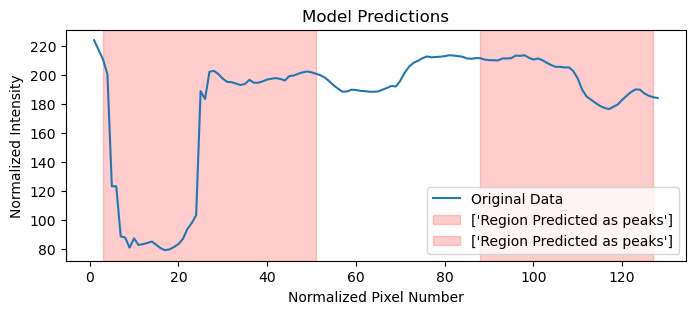

Using segmentation model trained on CT data


4/4 [==============================] - 0s 646us/step


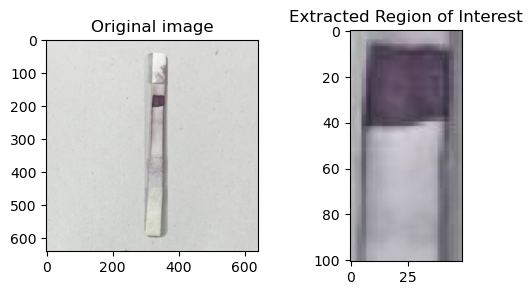

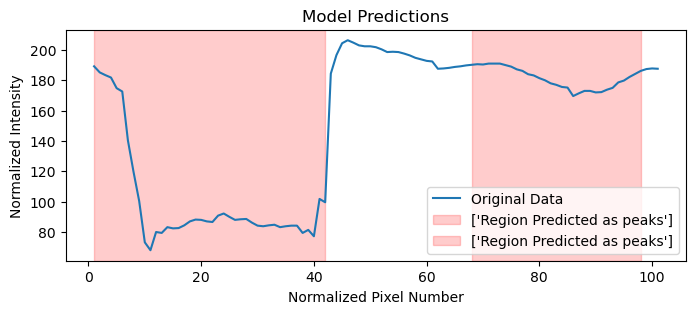

Using segmentation model trained on CT data


4/4 [==============================] - 0s 940us/step


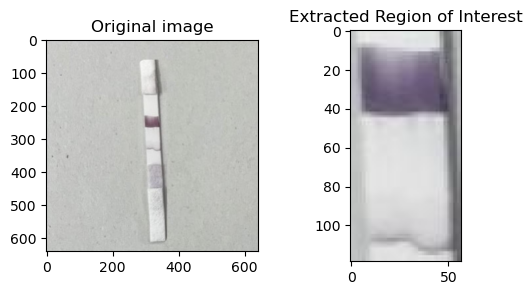

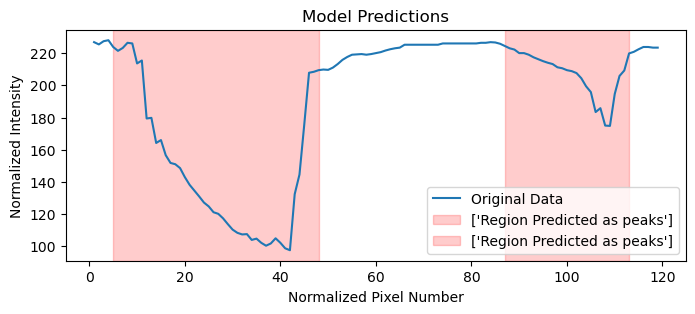

Using segmentation model trained on CT data


4/4 [==============================] - 0s 791us/step


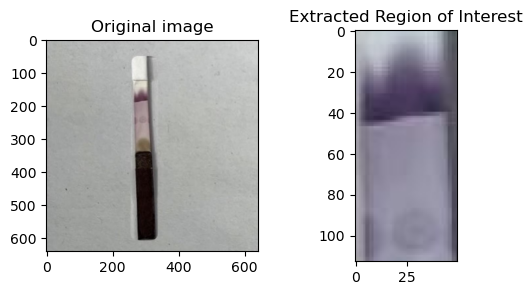

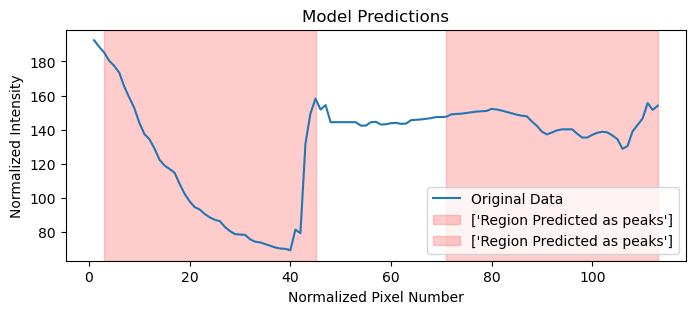

Using segmentation model trained on CT data


4/4 [==============================] - 0s 706us/step


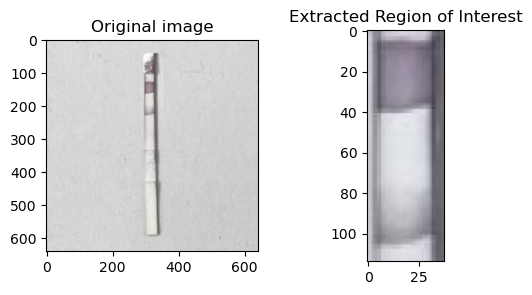

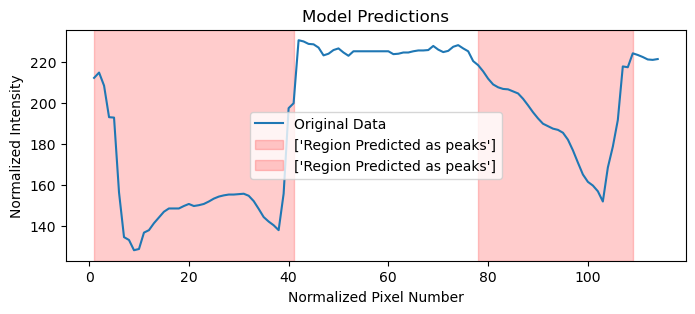

Using segmentation model trained on CT data


6/6 [==============================] - 0s 587us/step


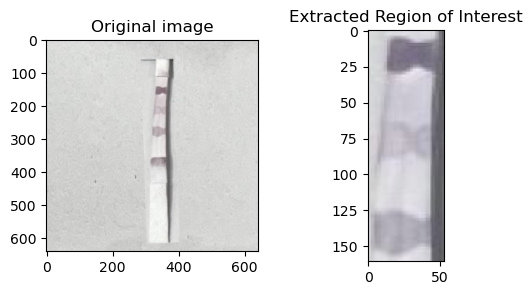

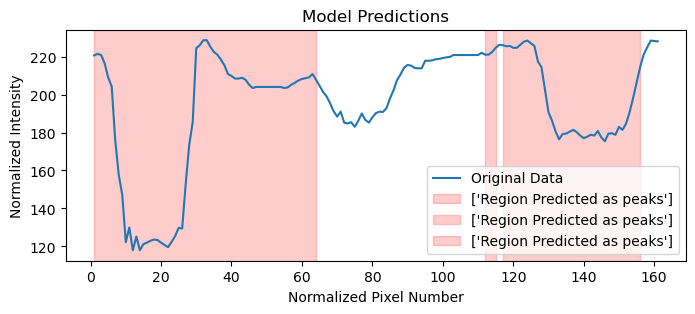

Using segmentation model trained on CAT data


6/6 [==============================] - 0s 554us/step


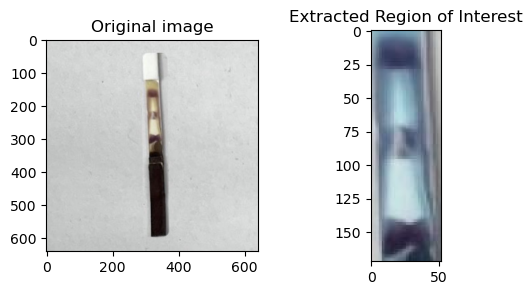

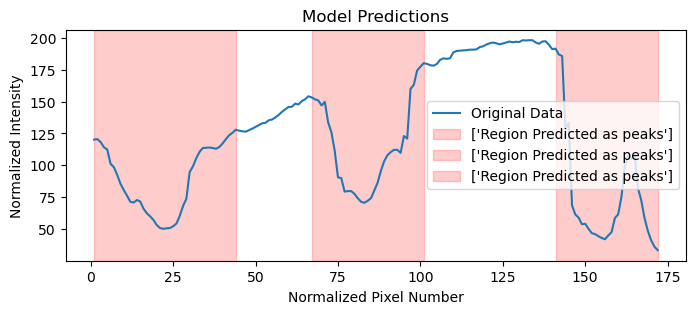

Using segmentation model trained on CT data


5/5 [==============================] - 0s 617us/step


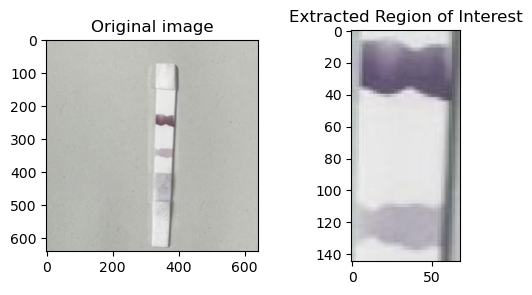

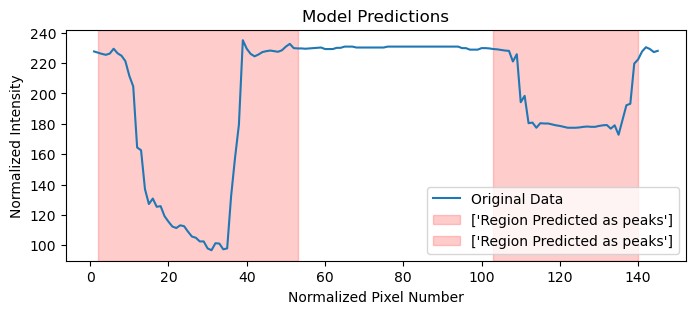

Using segmentation model trained on CAT data


5/5 [==============================] - 0s 575us/step


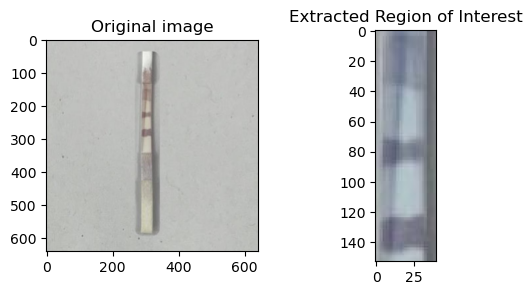

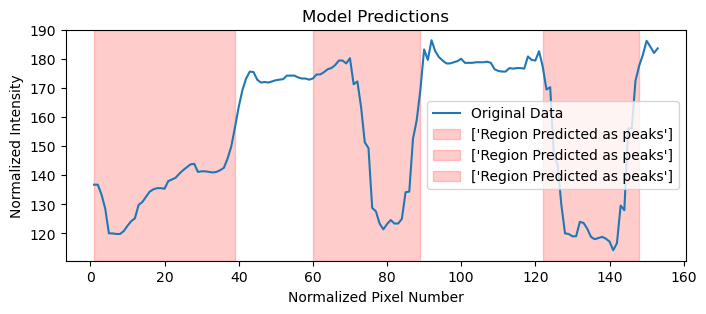

Using segmentation model trained on CAT data


4/4 [==============================] - 0s 795us/step


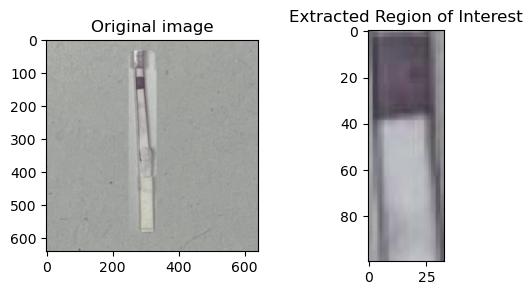

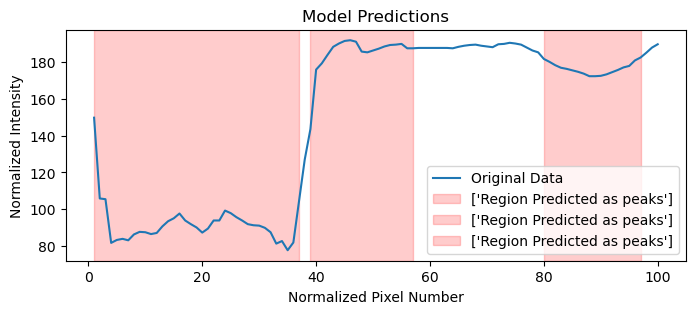

Using segmentation model trained on CT data


5/5 [==============================] - 0s 607us/step


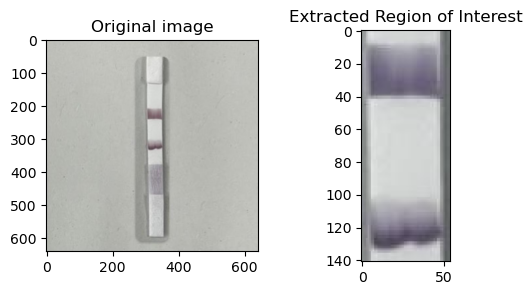

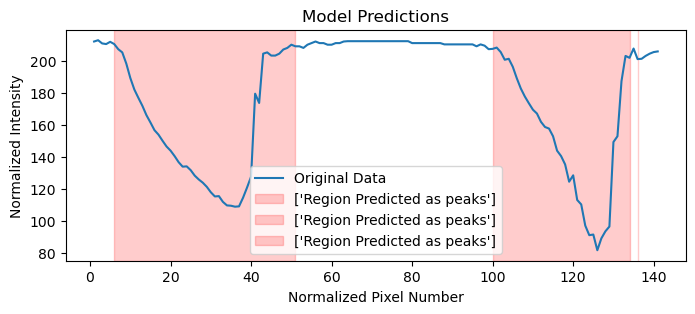

Using segmentation model trained on CT data


5/5 [==============================] - 0s 568us/step


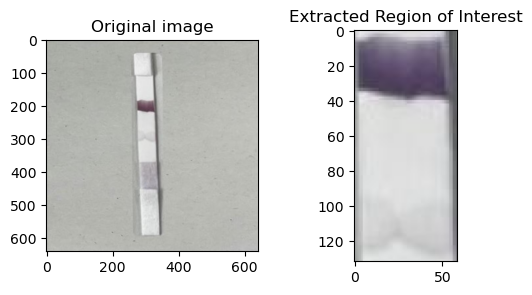

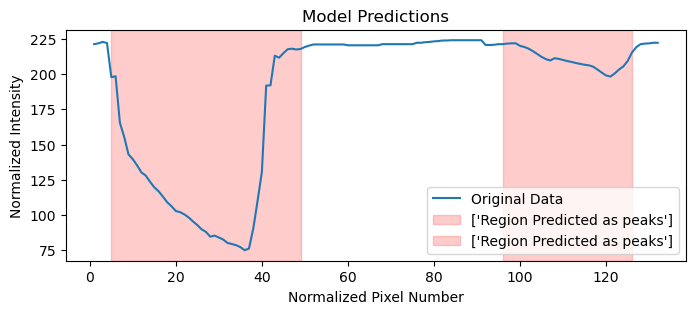

Using segmentation model trained on CAT data


5/5 [==============================] - 0s 730us/step


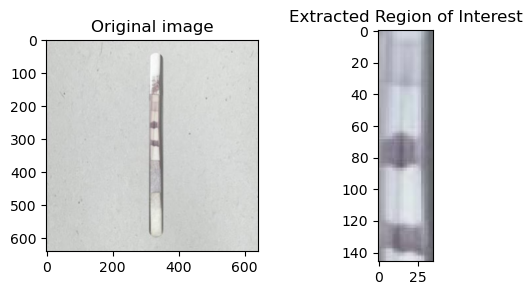

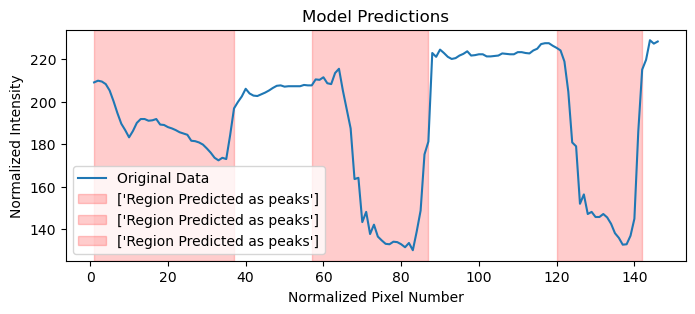

Using segmentation model trained on CT data


4/4 [==============================] - 0s 680us/step


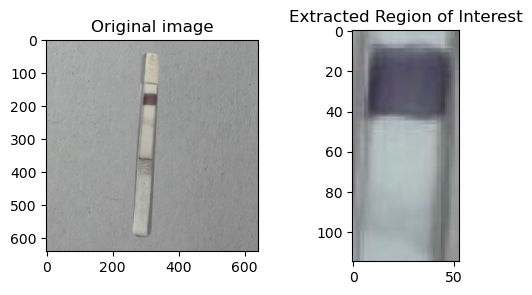

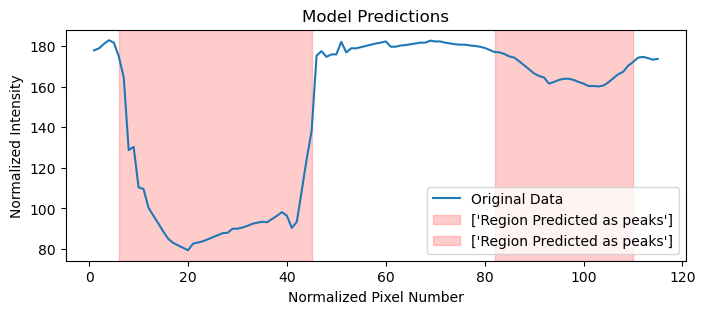

Using segmentation model trained on CT data


4/4 [==============================] - 0s 670us/step


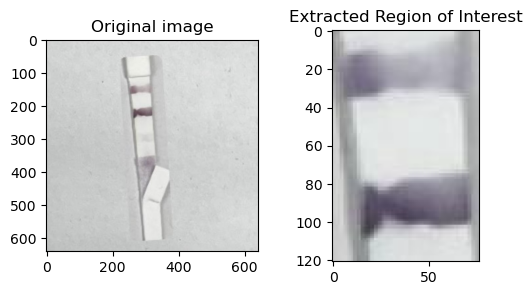

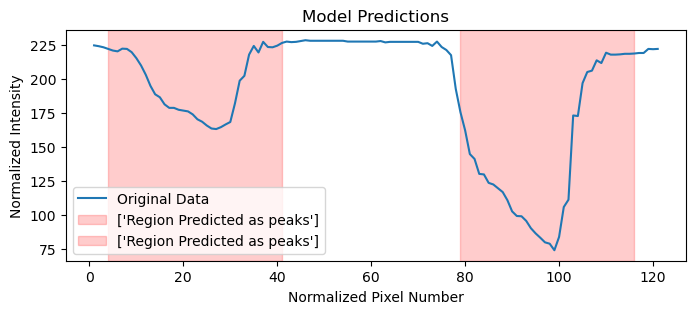

Using segmentation model trained on CAT data


5/5 [==============================] - 0s 605us/step


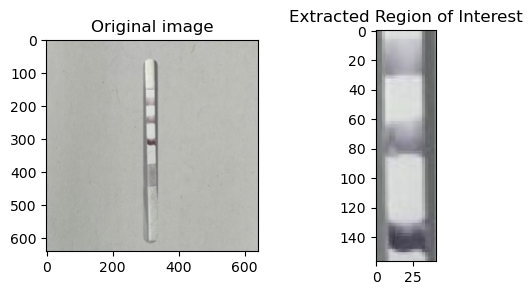

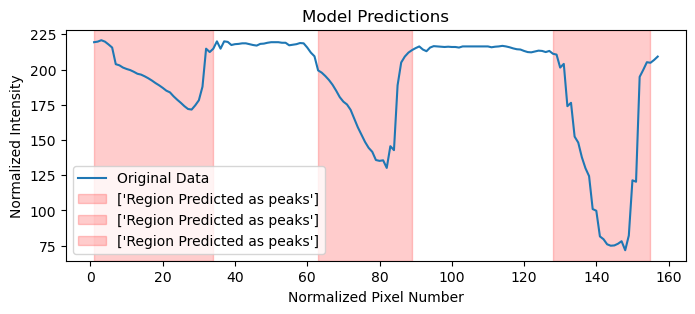

Using segmentation model trained on CAT data


3/3 [==============================] - 0s 766us/step


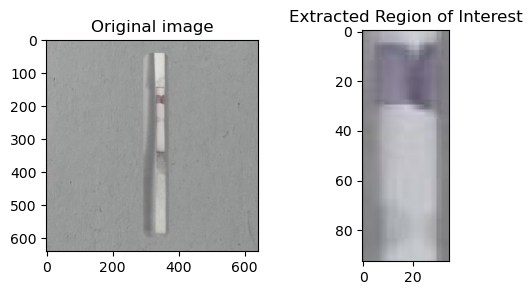

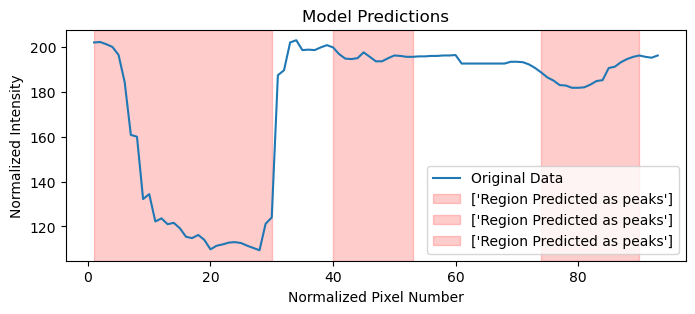

Using segmentation model trained on CAT data


4/4 [==============================] - 0s 658us/step


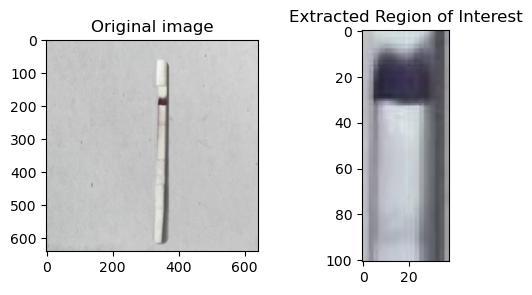

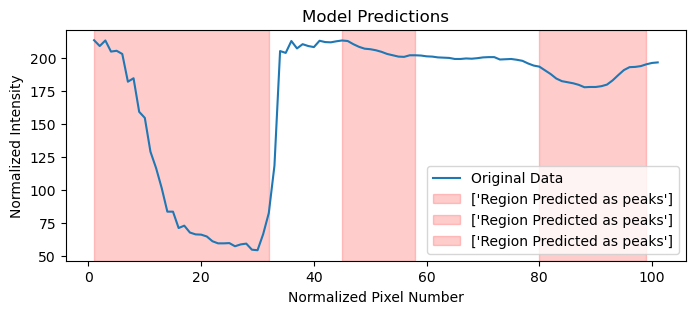

Using segmentation model trained on CT data


3/3 [==============================] - 0s 809us/step


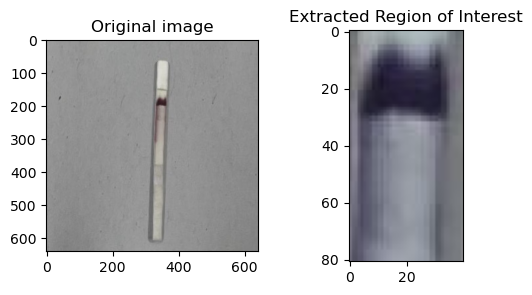

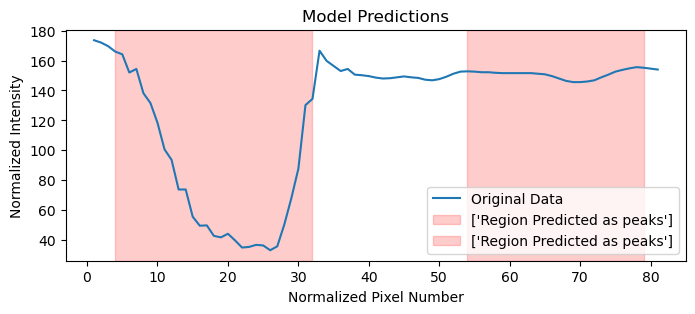

Using segmentation model trained on CAT data


6/6 [==============================] - 0s 606us/step


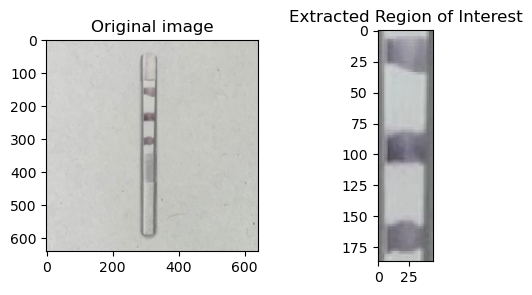

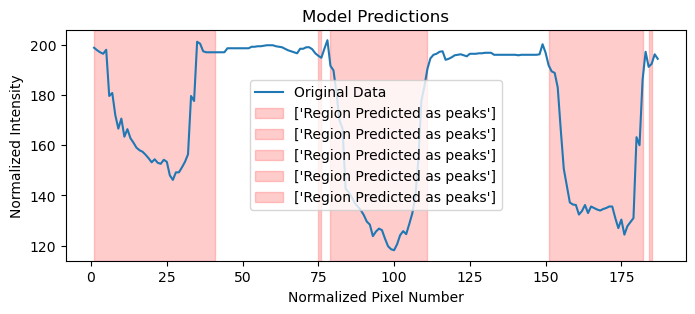

Using segmentation model trained on CAT data


4/4 [==============================] - 0s 664us/step


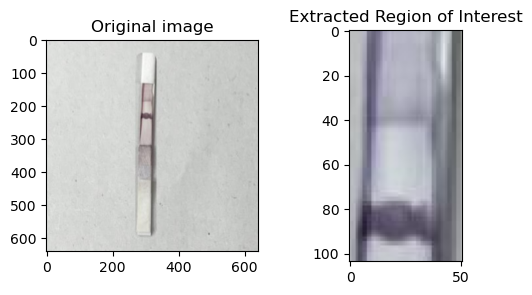

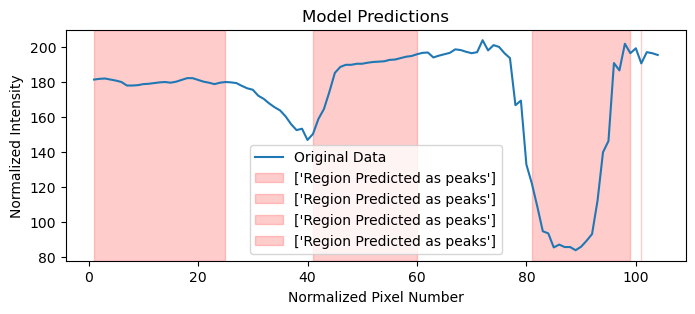

Using segmentation model trained on CT data


4/4 [==============================] - 0s 673us/step


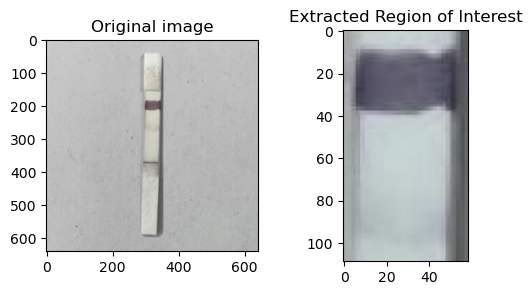

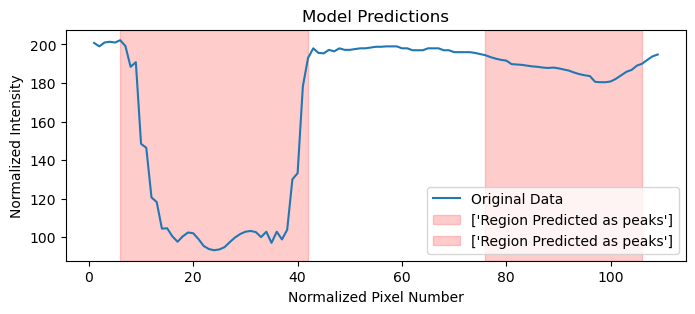

Using segmentation model trained on CT data


5/5 [==============================] - 0s 598us/step


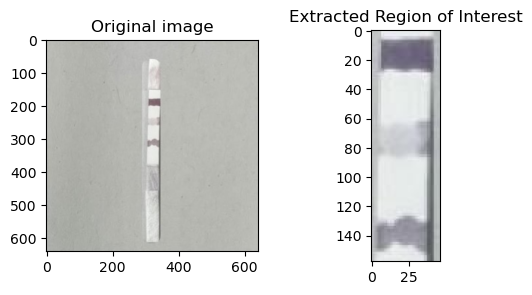

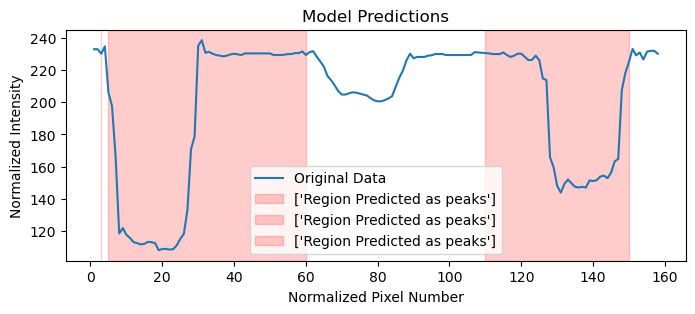

Using segmentation model trained on CT data


6/6 [==============================] - 0s 742us/step


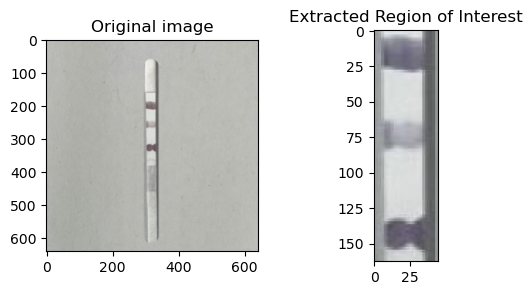

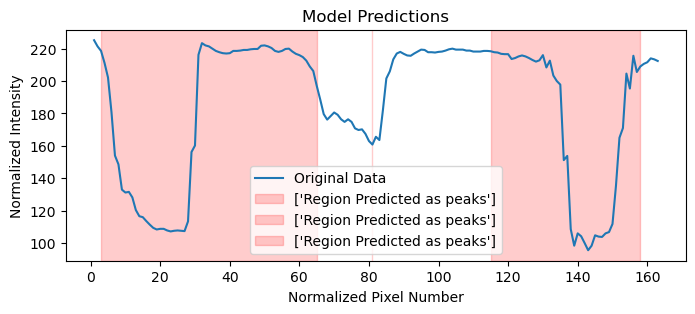

Using segmentation model trained on CT data


4/4 [==============================] - 0s 665us/step


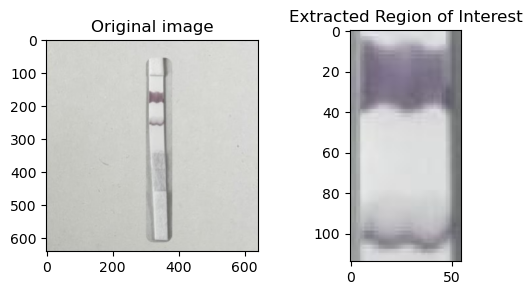

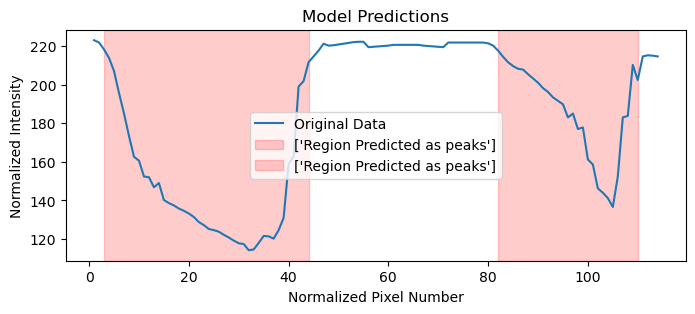

Using segmentation model trained on CT data


4/4 [==============================] - 0s 659us/step


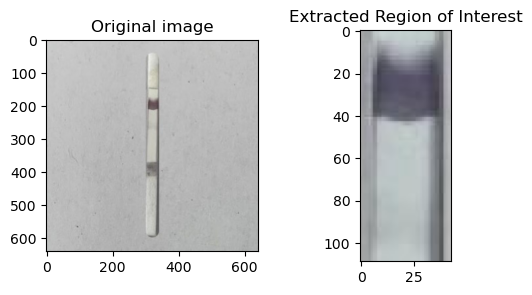

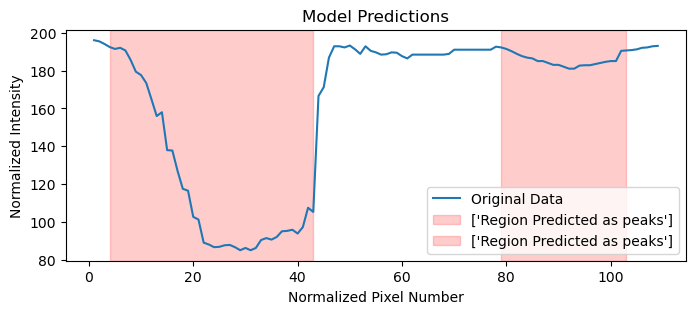

Using segmentation model trained on CT data


4/4 [==============================] - 0s 700us/step


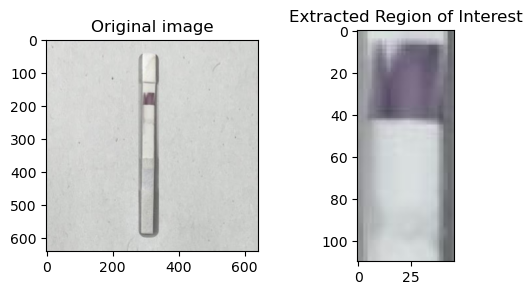

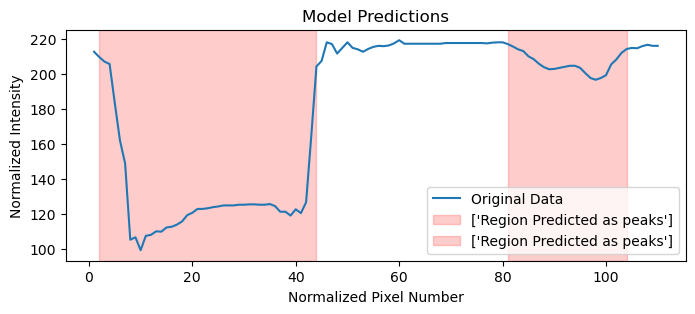

Using segmentation model trained on CT data


3/3 [==============================] - 0s 815us/step


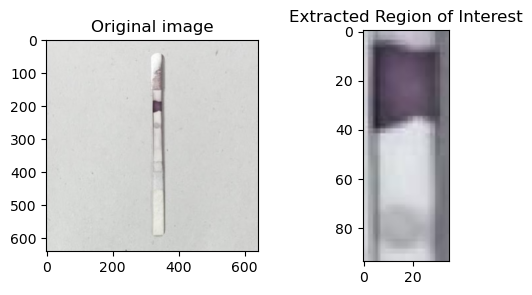

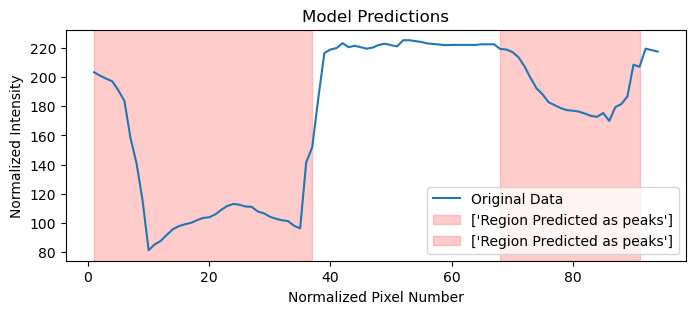

Using segmentation model trained on CT data


4/4 [==============================] - 0s 633us/step


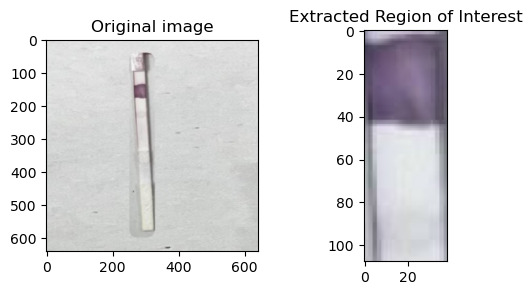

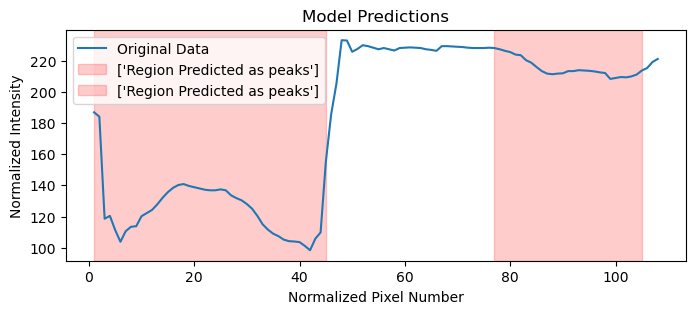

Using segmentation model trained on CAT data


4/4 [==============================] - 0s 684us/step


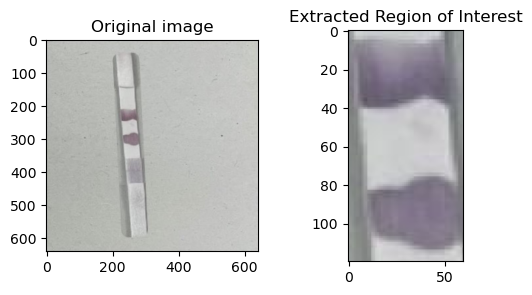

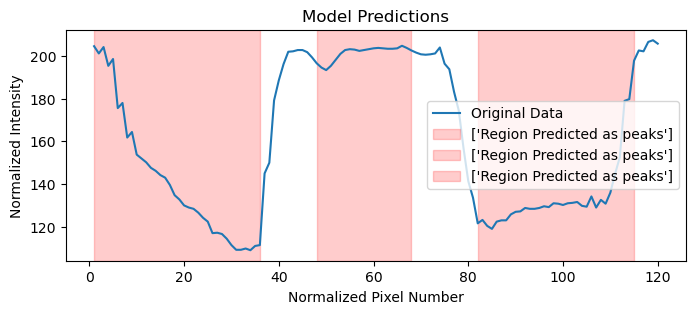

Using segmentation model trained on CAT data


4/4 [==============================] - 0s 653us/step


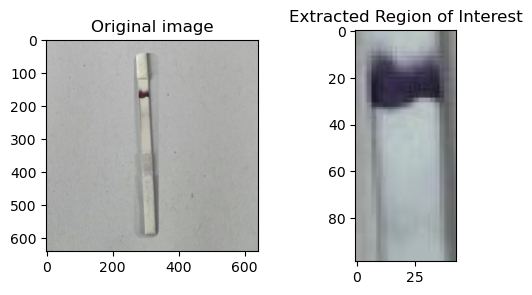

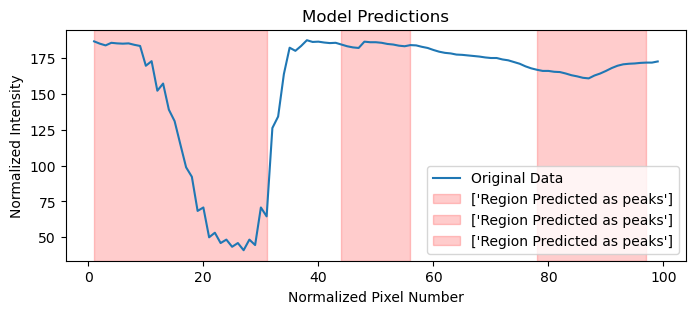

Using segmentation model trained on CAT data


4/4 [==============================] - 0s 674us/step


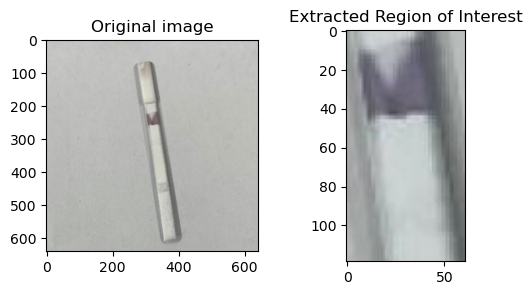

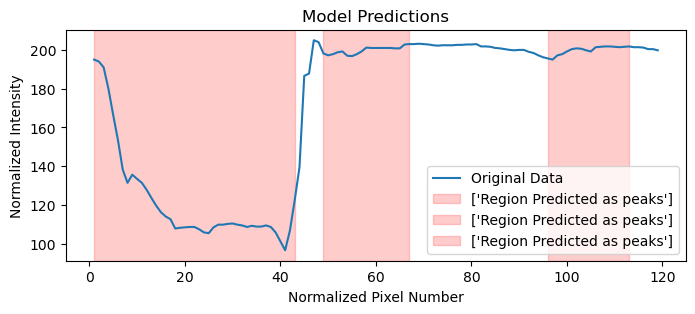

Using segmentation model trained on CT data


3/3 [==============================] - 0s 826us/step


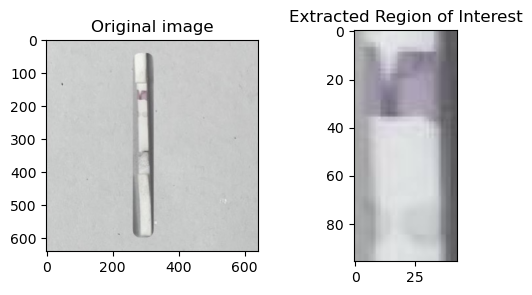

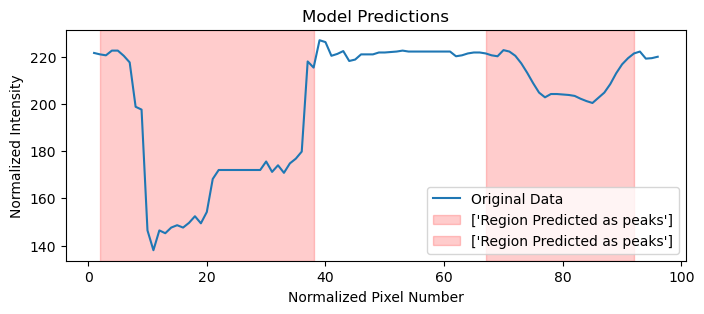

Using segmentation model trained on CAT data


4/4 [==============================] - 0s 678us/step


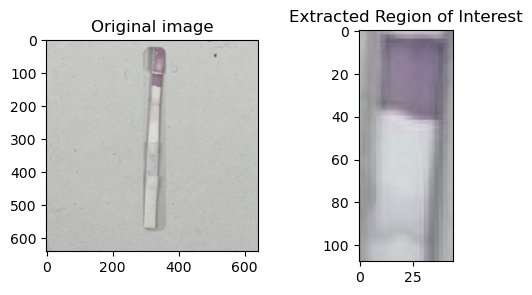

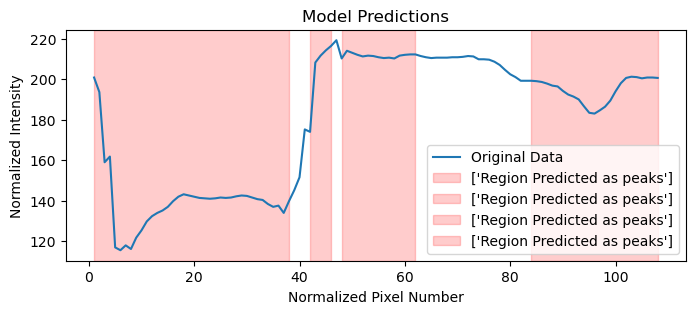

Using segmentation model trained on CT data


4/4 [==============================] - 0s 646us/step


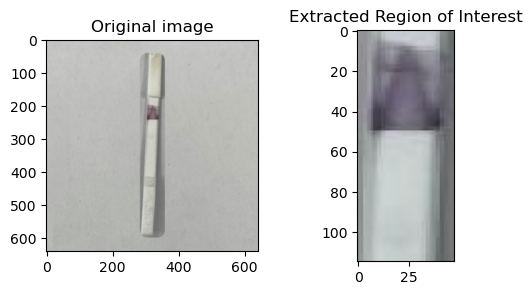

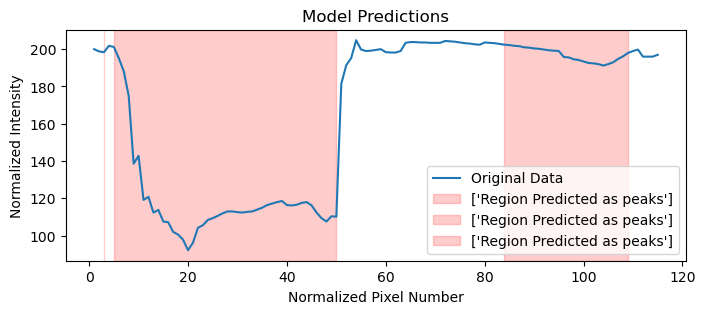

In [64]:
process_images(test_image_total_path)

# Test with CEA (05-04-23 image with C[0-100]

In [59]:
#function from logarithmic value 
def function(intensity_y):
    x = ((intensity_y - 10.244)/0.3794)
    return x
    

In [60]:
CEA_images = "/Users/ldosnon/Desktop/data_yolov8/RZD_yolov8_database/test/CEA_test/"

12-10_jpg.
Using segmentation model trained on CT data


4/4 [==============================] - 0s 676us/step


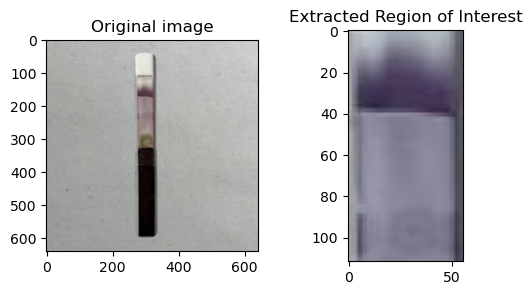

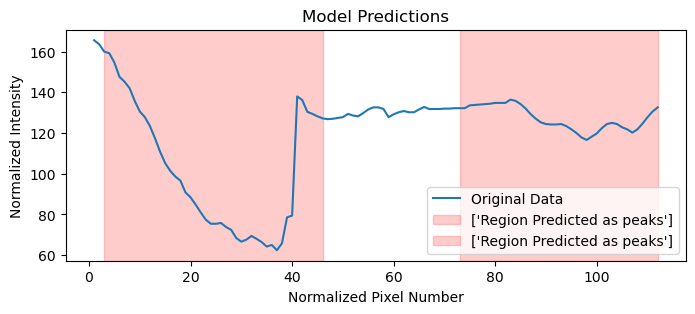

intensity of background is  130.19259259259258
intensity test line is  116.60000000000001
intensity test line is  13.592592592592567
corresponding concentration of CEA is  8.826021593549202
actual concentration of CEA is  12-10_jpg.
12-0_jpg.r
Using segmentation model trained on CT data


4/4 [==============================] - 0s 656us/step


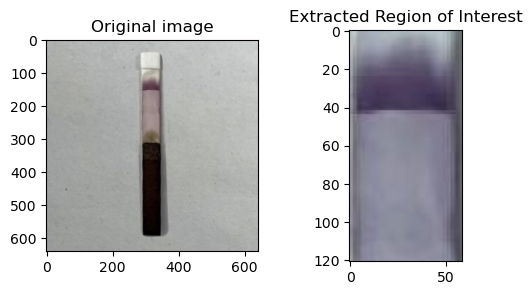

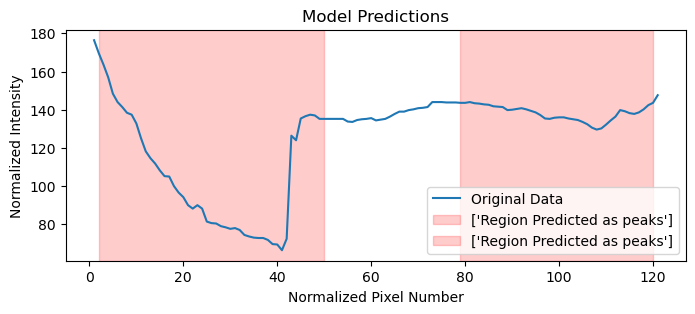

intensity of background is  138.17241379310346
intensity test line is  129.6
intensity test line is  8.572413793103465
corresponding concentration of CEA is  -4.405867703997193
actual concentration of CEA is  12-0_jpg.r
12-25_jpg.
Using segmentation model trained on CT data


4/4 [==============================] - 0s 659us/step


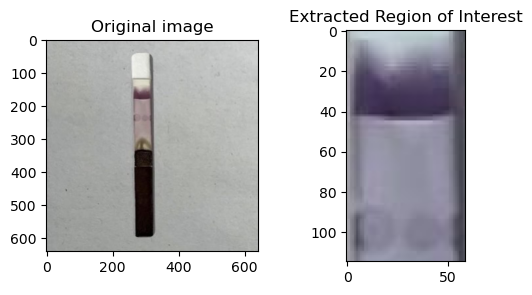

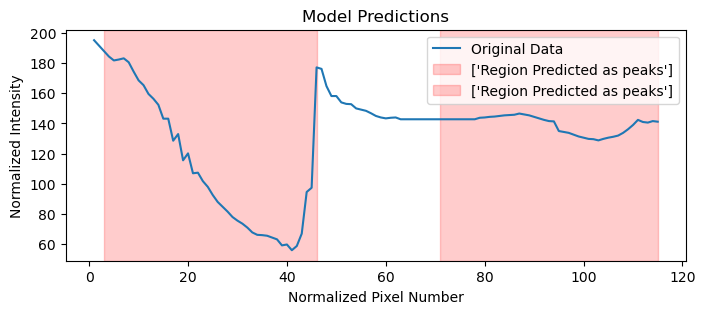

intensity of background is  150.056
intensity test line is  128.8
intensity test line is  21.256
corresponding concentration of CEA is  29.024775962045336
actual concentration of CEA is  12-25_jpg.
12-50_jpg.
Using segmentation model trained on CT data


4/4 [==============================] - 0s 639us/step


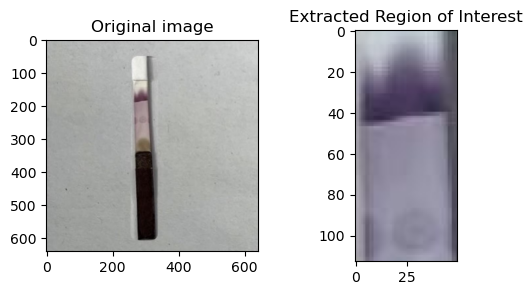

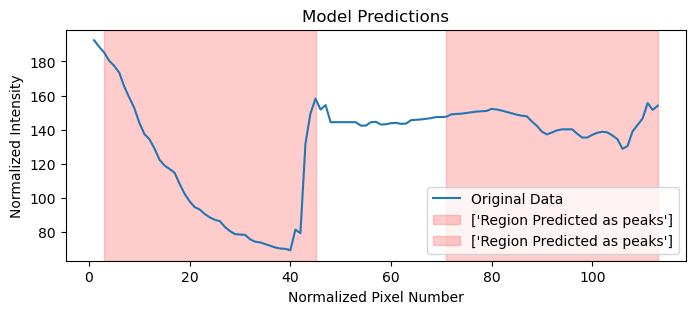

intensity of background is  145.80769230769232
intensity test line is  128.8
intensity test line is  17.00769230769231
corresponding concentration of CEA is  17.827338712947572
actual concentration of CEA is  12-50_jpg.
12-100_jpg
Using segmentation model trained on CAT data


4/4 [==============================] - 0s 665us/step


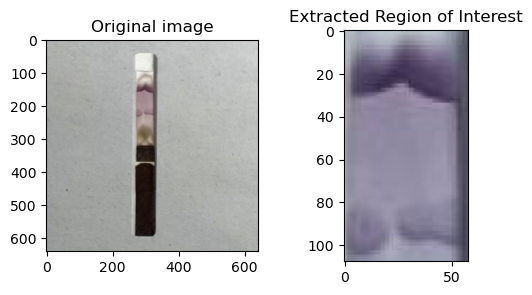

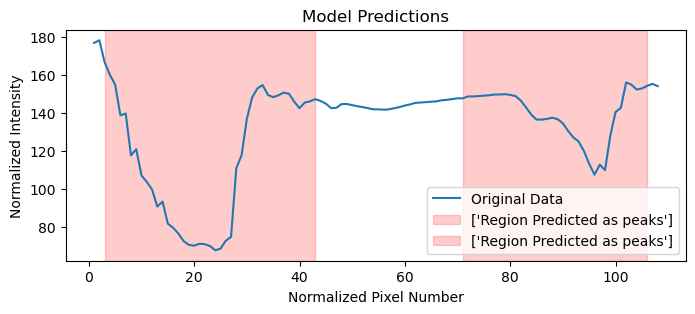

intensity of background is  144.35714285714283
intensity test line is  107.4
intensity test line is  36.95714285714283
corresponding concentration of CEA is  70.40891633406122
actual concentration of CEA is  12-100_jpg
12-80_jpg.
Using segmentation model trained on CT data


4/4 [==============================] - 0s 666us/step


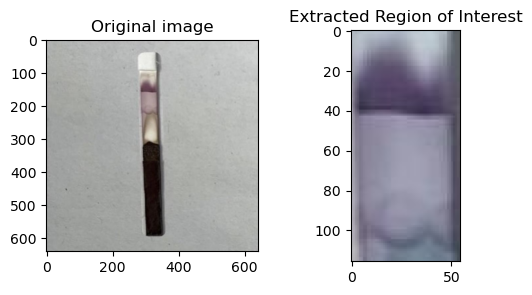

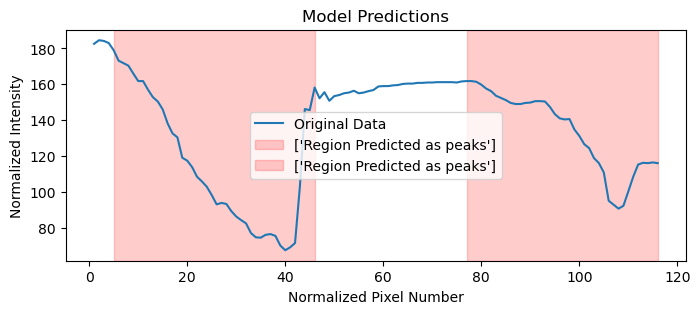

intensity of background is  158.13548387096773
intensity test line is  90.6
intensity test line is  67.53548387096774
corresponding concentration of CEA is  151.00549254340467
actual concentration of CEA is  12-80_jpg.


In [61]:
for filename in os.listdir(CEA_images):
    if filename.endswith(('.jpg', '.png', '.jpeg')):
        print(filename[0:10])
        scaler = MinMaxScaler()
        image_path = os.path.join(CEA_images, filename)
        X, region_pred, binary_prediction = plot_predictions(image_path)
        peak1_zone = region_pred[0]
        peak2_zone = region_pred[1]
        background_region = X[peak1_zone[-1]:peak2_zone[0],0]
        intensity_background = np.mean(X[peak1_zone[-1]:peak2_zone[0],1])
        intensity_control = min(X[peak1_zone[0]:peak1_zone[-1],1])
        intensity_test = min(X[peak2_zone[0]:peak2_zone[-1],1])
        intensity_test_normalized = intensity_background - intensity_test
        print("intensity of background is ", intensity_background)
        print("intensity test line is ", intensity_test)
        print("intensity test line is ", intensity_test_normalized)
        print("corresponding concentration of CEA is ", function(intensity_test_normalized))
        print("actual concentration of CEA is ", filename[0:10])